In [72]:
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [73]:
# pre config
PATH = "cls10.pt"
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# 添加一层全连接层，将特征矩阵维数转为标签数
model.fc = torch.nn.Linear(num_ftrs, 12)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

d:\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
Transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# test为验证数据集的目录
test_dataset = datasets.ImageFolder("test", Transform)
test_dataset_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

In [75]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [76]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    model.eval()
    res = {}
    err = {}
    with torch.no_grad():
        for i, (inputs, labels) in tqdm.tqdm(enumerate(test_dataset_loader),leave=False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for idx in tqdm.tqdm(range(len(preds))):
                if(preds[idx] == labels[idx]):
                    res[test_dataset.classes[preds[idx]]] = res.get(test_dataset.classes[preds[idx]], 0) + 1
                else:
                    err[test_dataset.classes[preds[idx]]] = err.get(test_dataset.classes[preds[idx]], 0) + 1
            if(i % 4 != 0): continue
            for j in range(inputs.size()[0]):
                if images_so_far == num_images:
                    break
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {test_dataset.classes[preds[j]]} real: {test_dataset.classes[labels[j]]}')
                imshow(inputs.cpu().data[j])
                
    return (res,err)

In [77]:
cls_num = {'Bedroom': 170, 'Dining Room': 39, 'Edwardian Suite': 17, 'Exterior': 17, 'Fitzgerald Suite': 33, 'Hardenbergh Terrace Suite': 28, 'Plaza Suite': 24, 'Royal Suite': 24, 'The Eloise Suite': 13, 'The Palm Court': 23, 'The Plaza Food Hall': 27, 'The Royal Plaza Suite': 26}

100%|██████████| 6/6 [00:00<?, ?it/s]


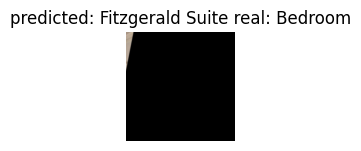

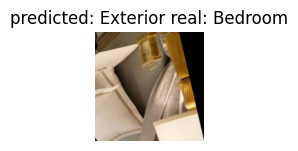

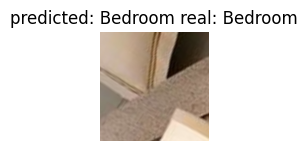

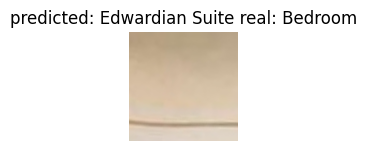

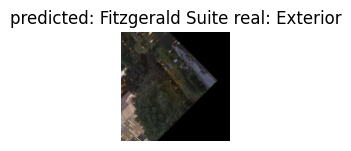

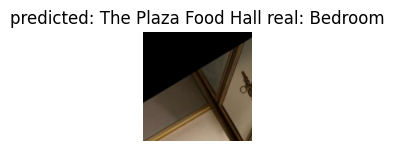

100%|██████████| 3/3 [00:00<?, ?it/s]
                       

正确率：{'Bedroom': '41.2%', 'The Plaza Food Hall': '88.9%', 'Fitzgerald Suite': '78.8%', 'Edwardian Suite': '29.4%', 'Dining Room': '20.5%', 'Hardenbergh Terrace Suite': '67.9%', 'Exterior': '17.6%', 'Plaza Suite': '83.3%', 'The Palm Court': '39.1%', 'Royal Suite': '12.5%', 'The Royal Plaza Suite': '3.8%', 'The Eloise Suite': '7.7%'}
 错误率：{'Fitzgerald Suite': '233.3%', 'Exterior': '105.9%', 'Edwardian Suite': '135.3%', 'The Plaza Food Hall': '155.6%', 'The Palm Court': '126.1%', 'The Royal Plaza Suite': '26.9%', 'Bedroom': '5.9%', 'Dining Room': '41.0%', 'Royal Suite': '33.3%', 'Hardenbergh Terrace Suite': '25.0%', 'The Eloise Suite': '30.8%', 'Plaza Suite': '45.8%'}


In [78]:
(cor,err) = visualize_model(model)
correct = {k: f"{v/cls_num[k] * 100:>0.1f}%" for k, v in cor.items()}
error = {k: f"{v/cls_num[k] * 100:>0.1f}%" for k, v in err.items()}
print(f"正确率：{correct}\n 错误率：{error}")